#03 — Feature Engineering

**Goal:** Create clear, business-friendly features from the cleaned loan dataset to improve model signal and interpretability.

Feature Engineering Pipeline for Loan Repayment Analytics

This notebook loads raw interim data, derives and transforms features, stores output datasets, and saves visualizations to the images folder. Each step blends code, result analysis, and detailed commentary for stakeholder clarity.

This covers:
1. **Feature Creation** — domain features (Income-to-Loan Ratio, EMI, Balance Income, Bands)
2. **Feature Transformation** — encoding, log transforms, binning
3. **Feature Selection** — correlation, ANOVA/chi², model-based importances
4. **Feature Extraction** — PCA for compact signal & an example interaction term
5. **Feature Scaling** — Standardization vs Min–Max and when to use each

> **Good practice:** transformations are fit on training folds only in modelling; here we demonstrate concepts on the whole data to illustrate outcomes.

In [1]:
# Environment setup for EDA
import sys
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA


# ---------- visual style (colorblind-friendly) ----------
# Use seaborn colorblind palette & set matplotlib params for readability
# Choose  palette: okabe_ito, pro_palette, or civic_palette
okabe_ito = ["#E69F00","#56B4E9","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7","#999999"]
sns.set_theme(context="notebook", style="whitegrid", font_scale=1.05)
sns.set_palette(okabe_ito)

plt.rcParams.update({
    "axes.edgecolor": "#444444",
    "axes.labelcolor": "#222222",
    "xtick.color": "#444444",
    "ytick.color": "#444444",
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "figure.dpi": 130,
    "grid.color": "#e5e5e5",
    "axes.facecolor": "#fafafa",
    "figure.facecolor": "white"
})

In [2]:
!mkdir -p Loan_Repayment_Behaviour_Analytics/{data/raw,data/interim,data/processed,notebooks,images,reports,src}
!touch Loan_Repayment_Behaviour_Analytics/{README.md,requirements.txt}
!ls -R Loan_Repayment_Behaviour_Analytics

Loan_Repayment_Behaviour_Analytics:
data  images  notebooks  README.md  reports  requirements.txt  src

Loan_Repayment_Behaviour_Analytics/data:
interim  processed  raw

Loan_Repayment_Behaviour_Analytics/data/interim:

Loan_Repayment_Behaviour_Analytics/data/processed:

Loan_Repayment_Behaviour_Analytics/data/raw:

Loan_Repayment_Behaviour_Analytics/images:

Loan_Repayment_Behaviour_Analytics/notebooks:

Loan_Repayment_Behaviour_Analytics/reports:

Loan_Repayment_Behaviour_Analytics/src:


In [3]:
import sys
from pathlib import Path
# Add src folder to Python path (so imports work in notebooks)
ROOT = Path.cwd()
if ROOT.name == "content":
    ROOT = ROOT / "Loan_Repayment_Behaviour_Analytics"

# if running from notebooks folder, go up one level
elif ROOT.name.lower() == "notebooks":
    ROOT = ROOT.parent
ROOT

PosixPath('/content/Loan_Repayment_Behaviour_Analytics')

In [4]:
# ---  Environment Setup ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(str(ROOT / "src"))

from utils_paths import get_project_paths

paths = get_project_paths()

# Unpack for easy use
env = paths["env"]
DATA_RAW = paths["DATA_RAW"]
DATA_INTERIM = paths["DATA_INTERIM"]
DATA_PROCESSED = paths["DATA_PROCESSED"]
IMAGES = paths["IMAGES"]

print(f"Environment: {env}")
print("RAW:", DATA_RAW)
print("INTERIM:", DATA_INTERIM)
print("PROCESSED:", DATA_PROCESSED)

Environment: Colab
RAW: /content/Loan_Repayment_Behaviour_Analytics/data/raw
INTERIM: /content/Loan_Repayment_Behaviour_Analytics/data/interim
PROCESSED: /content/Loan_Repayment_Behaviour_Analytics/data/processed


In [5]:
# Load EDA-cleaned data
clean_path = DATA_INTERIM / 'loan_data_clean_start.csv'
df = pd.read_csv(clean_path)
# Ensure binary target 0/1
if df['Loan_Status'].dtype == object:
    df['Loan_Status'] = df['Loan_Status'].map({'Y':1,'N':0}).astype(int)

print('Loaded:', clean_path, 'shape=', df.shape)
df.head(3)


Loaded: /content/Loan_Repayment_Behaviour_Analytics/data/interim/loan_data_clean_start.csv shape= (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1


##Feature Creation:
Feature creation introduces **domain signal** that raw columns lack. We add:
- `TotalIncome` = ApplicantIncome + CoapplicantIncome
- `Income_to_Loan_Ratio` = TotalIncome / (LoanAmount × 1000)
- `EMI` = (LoanAmount × 1000) / Loan_Amount_Term
- `Balance_Income` = TotalIncome - EMI
- **Bands** for Income, LoanAmount, and Term via `pd.qcut` to capture behavioural thresholds.

In [6]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Income_to_Loan_Ratio'] = df['TotalIncome'] / (df['LoanAmount'] * 1000)
df['EMI'] = (df['LoanAmount'] * 1000) / df['Loan_Amount_Term']
df['Balance_Income'] = df['TotalIncome'] - df['EMI']


In [7]:
#print(df['ApplicantIncome'].value_counts())
#print(df['LoanAmount'].value_counts())
print(df['Loan_Amount_Term'].value_counts())

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64


In [8]:
# Behavioural Bands (quartiles)
df['Income_Band'] = pd.qcut(df['ApplicantIncome'], q=4, labels=['Low','MidLow','MidHigh','High'])
df['LoanAmt_Band'] = pd.qcut(df['LoanAmount'], q=4, labels=['Small','MidSmall','MidLarge','Large'])
df['Term_Band'] = pd.cut(df['Loan_Amount_Term'],bins=[0, 180, 300, 360, 480], labels=['Short','MidShort','MidLong','Long'],include_lowest=True)

In [9]:
# Quick correlation look with target for new numeric features
corr_feats = ['Income_to_Loan_Ratio','EMI','Balance_Income','TotalIncome']
print('Correlation with Loan_Status (new features only):')
print(df[corr_feats + ['Loan_Status']].corr()['Loan_Status'].sort_values(ascending=False))

Correlation with Loan_Status (new features only):
Loan_Status             1.000000
Income_to_Loan_Ratio    0.024234
EMI                    -0.015394
TotalIncome            -0.031271
Balance_Income         -0.036926
Name: Loan_Status, dtype: float64


##Feature Transformation
Transformations improve model learning by stabilising variance and expressing categories numerically.
- **Categorical Encoding**: One-hot encoding for `Property_Area`, `Education`, `Gender`, `Married`, `Self_Employed`.
- **Log Transforms**: Apply to skewed numeric variables (`ApplicantIncome`, `CoapplicantIncome`, `LoanAmount`).
- **Dummy/Binary**: Ensure `Credit_History` is strictly {0,1}.

In [10]:
# Log1p transforms for skew
for col in ['ApplicantIncome','CoapplicantIncome','LoanAmount']:
    df[f'log_{col}'] = np.log1p(df[col].clip(lower=0))

In [11]:
# Ensure binary for Credit_History if not already
if df['Credit_History'].dtype != int and df['Credit_History'].dtype != np.int64:
    # Ensure binary (0/1) and handle missing Credit_History: mark missing as 'Unknown' (2)
    df['Credit_History'] = (df['Credit_History'].replace({1.0: 1, 0.0: 0, '1': 1, '0': 0})\
                            .fillna(2).astype(int))


In [12]:
# One-hot encode selected categoricals (we'll keep encoded copy for selection/extraction demos)
cats = ['Property_Area','Education','Gender','Married','Self_Employed','Income_Band','LoanAmt_Band','Term_Band']
df_enc = pd.get_dummies(df, columns=cats, drop_first=True)
print('Encoded shape:', df_enc.shape)

Encoded shape: (614, 30)


##Feature Selection
Goal: keep **useful** features, remove redundant/noisy ones.
- **Correlation filter** (fast heuristic)
- **ANOVA (f_classif)** for numeric vs binary target
- **Chi-square** for non-negative encoded features vs target
- **Model-based** importance (Random Forest, Logistic Regression)

In [13]:
y = df_enc['Loan_Status']
X_all = df_enc.drop(columns=['Loan_Status'])


In [14]:
# Correlation (numeric only) with target
num_cols = X_all.select_dtypes(include=[np.number]).columns
corr_to_y = X_all[num_cols].corrwith(y).abs().sort_values(ascending=False)
print('Top correlations with target (abs):')
print(corr_to_y)

Top correlations with target (abs):
Credit_History           0.423212
log_CoapplicantIncome    0.060593
CoapplicantIncome        0.059187
log_LoanAmount           0.039386
LoanAmount               0.037318
Balance_Income           0.036926
TotalIncome              0.031271
Income_to_Loan_Ratio     0.024234
Loan_Amount_Term         0.021268
EMI                      0.015394
log_ApplicantIncome      0.010959
ApplicantIncome          0.004710
dtype: float64


In [15]:
# ANOVA F-test (numeric)
f_vals, f_p = f_classif(X_all[num_cols].fillna(0), y)
anova = pd.DataFrame({'feature': num_cols, 'F': f_vals, 'p': f_p}).sort_values('F', ascending=False).head(12)
print('\\nANOVA top features:')
print(anova)

\nANOVA top features:
                  feature           F             p
4          Credit_History  133.530817  4.467937e-28
10  log_CoapplicantIncome    2.255241  1.336785e-01
1       CoapplicantIncome    2.151457  1.429483e-01
11         log_LoanAmount    1.542918  2.146598e-01
6    Income_to_Loan_Ratio    1.092947  2.962320e-01
5             TotalIncome    0.599037  4.392445e-01
8          Balance_Income    0.115226  7.343877e-01
9     log_ApplicantIncome    0.073504  7.863932e-01
2              LoanAmount    0.069173  7.926335e-01
3        Loan_Amount_Term    0.032670  8.566255e-01
0         ApplicantIncome    0.013574  9.072878e-01
7                     EMI    0.010392  9.188382e-01


In [16]:
# Chi-square (requires non-negative features). We'll min-shift to >=0 for demo.
X_nonneg = X_all[num_cols].copy()
for c in X_nonneg.columns:
    print("col:",c)
    col = X_nonneg[c]
    if col.min() < 0:
        X_nonneg[c] = col - col.min()
chi_vals, chi_p = chi2(X_nonneg.fillna(0), y)
chisq = pd.DataFrame({'feature': X_nonneg.columns, 'chi2': chi_vals, 'p': chi_p}).sort_values('chi2', ascending=False).head(12)
print('\nChi-square top features:')
print(chisq)

col: ApplicantIncome
col: CoapplicantIncome
col: LoanAmount
col: Loan_Amount_Term
col: Credit_History
col: TotalIncome
col: Income_to_Loan_Ratio
col: EMI
col: Balance_Income
col: log_ApplicantIncome
col: log_CoapplicantIncome
col: log_LoanAmount

Chi-square top features:
                  feature          chi2             p
1       CoapplicantIncome  11342.041603  0.000000e+00
5             TotalIncome   3559.550362  0.000000e+00
8          Balance_Income    213.872308  1.963693e-48
0         ApplicantIncome     93.904964  3.310429e-22
4          Credit_History     26.110887  3.223613e-07
10  log_CoapplicantIncome      7.880856  4.996082e-03
7                     EMI      6.276411  1.223557e-02
2              LoanAmount      3.829885  5.034638e-02
3        Loan_Amount_Term      0.661295  4.161030e-01
11         log_LoanAmount      0.348375  5.550345e-01
6    Income_to_Loan_Ratio      0.032676  8.565510e-01
9     log_ApplicantIncome      0.003672  9.516809e-01


In [17]:
# Keep only numeric columns (model-safe)
X_rf = X_all.select_dtypes(include=[np.number]).fillna(0)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=400, random_state=42)
rf.fit(X_rf, y)

# Importance scores
imp = pd.Series(rf.feature_importances_, index=X_rf.columns).sort_values(ascending=False)

# Display top 12
print("\nRandomForest top importances:")
print(imp.head(12))


RandomForest top importances:
Credit_History           0.266217
Income_to_Loan_Ratio     0.105359
TotalIncome              0.091475
ApplicantIncome          0.084587
log_ApplicantIncome      0.080955
Balance_Income           0.074769
EMI                      0.065442
log_LoanAmount           0.062468
LoanAmount               0.059406
CoapplicantIncome        0.045582
log_CoapplicantIncome    0.041754
Loan_Amount_Term         0.021987
dtype: float64


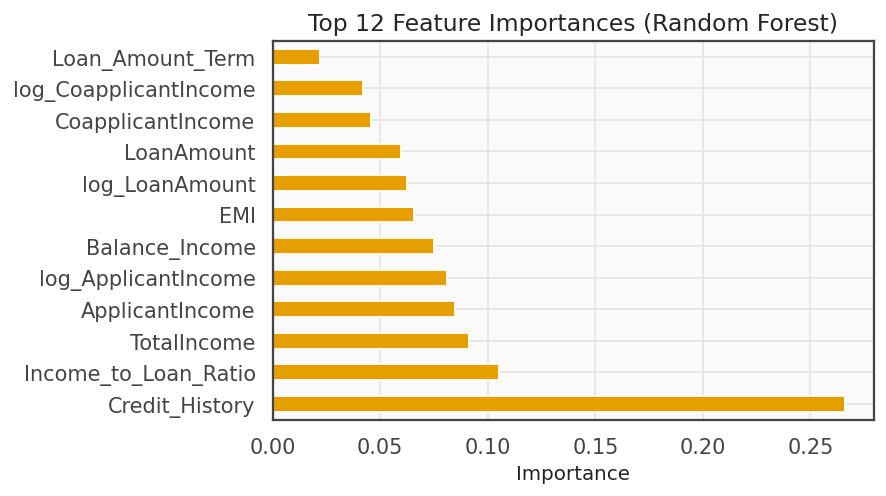

In [33]:
plt.figure(figsize=(7,4))
imp.plot(kind="barh")
plt.title("Top 12 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(IMAGES/"rf_feature_importances.png", dpi=140)
plt.show()

In [18]:
#Logistic regression coefficients (with standardization)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_scaled = sc.fit_transform(X_rf)
lr = LogisticRegression(max_iter=200, solver='lbfgs')
lr.fit(X_scaled, y)
coef = pd.Series(lr.coef_[0], index=X_rf.columns).abs().sort_values(ascending=False).head(12)
print('\nLogistic Regression top |coefficients|:')
print(coef)



Logistic Regression top |coefficients|:
Credit_History           1.188451
CoapplicantIncome        0.464011
log_CoapplicantIncome    0.425867
Balance_Income           0.224313
TotalIncome              0.209055
log_LoanAmount           0.152913
Income_to_Loan_Ratio     0.148347
Loan_Amount_Term         0.131045
EMI                      0.112859
LoanAmount               0.092595
log_ApplicantIncome      0.080856
ApplicantIncome          0.001243
dtype: float64


##Feature Extraction
- **PCA** compresses many correlated features into fewer components while retaining most variance.
- **Interaction Terms** explicitly capture joint effects (e.g., affordability × trust).

In [19]:
# Scale then PCA
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(X_rf.fillna(0))

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled_full)

print(f'PCA retained {pca.n_components_} components for 95% variance (from {X_all.shape[1]} features).')


PCA retained 8 components for 95% variance (from 29 features).


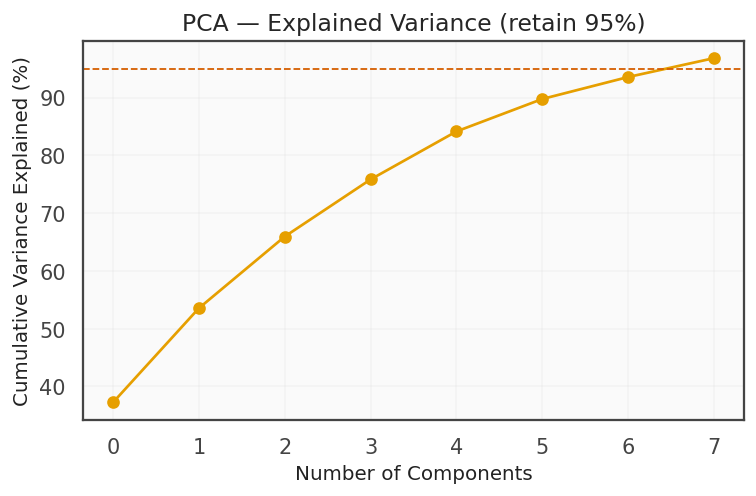

,TotalIncome,Credit_History,Income_x_CreditHistory
0,5849.0,1,5849.0
1,6091.0,1,6091.0
2,3000.0,1,3000.0


In [35]:
# Cumulative variance plot
cum = np.cumsum(pca.explained_variance_ratio_) * 100
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(cum, marker='o')
plt.axhline(95, color='#D55E00', linestyle='--', linewidth=1)
plt.ylabel('Cumulative Variance Explained (%)')
plt.xlabel('Number of Components')
plt.title('PCA — Explained Variance (retain 95%)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(IMAGES/'pca_explained_variance.png')
plt.show()

# Example interaction term on original df
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Income_x_CreditHistory'] = df['TotalIncome'] * df['Credit_History']
df[['TotalIncome','Credit_History','Income_x_CreditHistory']].head(3)

##Feature Scaling
Scaling ensures features contribute comparably in distance‑ or gradient‑based models.
- **Standardization (Z-score)**: mean 0, std 1 — good for Logistic Regression/SVM.
- **Min-Max scaling**: rescale to [0,1] — common for neural nets or bounded features.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
to_scale = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term',
            'Income_to_Loan_Ratio','EMI','Balance_Income']

sc_std = StandardScaler()
sc_mmx = MinMaxScaler()

std_vals = sc_std.fit_transform(df[to_scale])
mmx_vals = sc_mmx.fit_transform(df[to_scale])

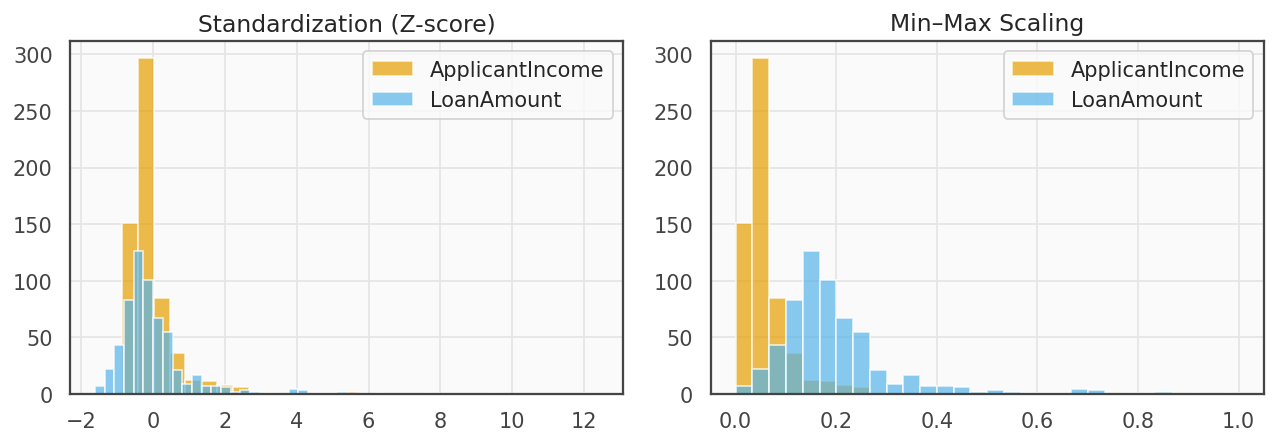

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,3.6))
axes[0].hist(std_vals[:,0], bins=30, alpha=0.7, label='ApplicantIncome')
axes[0].hist(std_vals[:,2], bins=30, alpha=0.7, label='LoanAmount')
axes[0].set_title('Standardization (Z-score)'); axes[0].legend()

axes[1].hist(mmx_vals[:,0], bins=30, alpha=0.7, label='ApplicantIncome')
axes[1].hist(mmx_vals[:,2], bins=30, alpha=0.7, label='LoanAmount')
axes[1].set_title('Min–Max Scaling'); axes[1].legend()

plt.tight_layout()
plt.savefig(IMAGES/'scaling_comparison.png',dpi=140)
plt.show()

## Collinearity Review (VIF)

Quantify multicollinearity among numeric predictors using **Variance Inflation Factor (VIF)**.

- Rule of thumb: **VIF > 5** indicates notable multicollinearity; **>10** is severe.
- May keep correlated features **if** they have strong interpretability (e.g., `TotalIncome` vs. `Income_to_Loan_Ratio`).
- Iteratively drop the **highest VIF** feature until all remaining are ≤ threshold or explicitly whitelisted.


In [21]:
# VIF on numeric predictors (post-feature engineering)
# Safe import (installs statsmodels if missing)
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels", "-q"])
    from statsmodels.stats.outliers_influence import variance_inflation_factor

import numpy as np
import pandas as pd

# Candidate numeric features (keep to those present)
num_features_vif = [
    "ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term",
    "TotalIncome","Income_to_Loan_Ratio","EMI","Balance_Income","Income_x_CreditHistory"
]
num_features_vif = [c for c in num_features_vif if c in df.columns]

X_num = df[num_features_vif].copy()
X_num = X_num.replace([np.inf, -np.inf], np.nan).fillna(0)

def compute_vif_frame(X):
    X_ = X.copy()
    # Guard against constant columns (VIF undefined) by adding tiny noise if needed
    for c in X_.columns:
        if X_[c].std() == 0:
            X_[c] = X_[c] + np.random.normal(0, 1e-9, size=len(X_))
    vif = pd.DataFrame({
        "feature": X_.columns,
        "VIF": [variance_inflation_factor(X_.values, i) for i in range(X_.shape[1])]
    })
    return vif.sort_values("VIF", ascending=False).reset_index(drop=True)

vif0 = compute_vif_frame(X_num)
vif0


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,ApplicantIncome,inf
1,CoapplicantIncome,inf
2,TotalIncome,inf
3,Balance_Income,31.550523
4,LoanAmount,9.236675
5,Loan_Amount_Term,5.460039
6,Income_to_Loan_Ratio,4.462590
7,Income_x_CreditHistory,4.258347
8,EMI,2.593731


**Iterative VIF pruning** (optional): drop highest-VIF feature stepwise until all ≤ 5, except for features kept by **policy/interpretability**.


In [22]:
# OPTIONAL: iterative pruning
VIF_CUTOFF = 5.0

# Features we intentionally keep even if VIF is high (interpretability policy)
whitelist = {"Income_to_Loan_Ratio", "EMI"}  # edit as needed

X_work = X_num.copy()
dropped = []

while True:
    vif = compute_vif_frame(X_work)
    worst = vif.iloc[0]
    if worst["VIF"] <= VIF_CUTOFF:
        break
    feat = worst["feature"]
    if feat in whitelist:
        # find next worst not in whitelist
        non_white = vif[~vif["feature"].isin(whitelist)]
        if non_white.empty or non_white.iloc[0]["VIF"] <= VIF_CUTOFF:
            break
        feat = non_white.iloc[0]["feature"]
    X_work = X_work.drop(columns=[feat])
    dropped.append((feat, float(worst["VIF"])))

vif_final = compute_vif_frame(X_work)
print("Dropped for VIF >", VIF_CUTOFF, ":", dropped)
vif_final


Dropped for VIF > 5.0 : [('ApplicantIncome', inf), ('TotalIncome', 34.138863009535974), ('LoanAmount', 9.235031115833156)]


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,Balance_Income,4.636443
1,Income_x_CreditHistory,3.944774
2,Income_to_Loan_Ratio,3.509915
3,Loan_Amount_Term,2.676195
4,EMI,1.885965
5,CoapplicantIncome,1.682345


**Decision:**  
- Keep affordability signals (`Income_to_Loan_Ratio`, `EMI`) for interpretability, even if correlated with `TotalIncome`/`LoanAmount`.  
- If any feature was auto-dropped above, note it in the modelling report as a governance decision.


##Leakage Audit

We check that no feature leaks future or outcome information (e.g., post-decision amounts, labels encoded in features, or direct transforms of the target).
- **Conceptual**: No post-outcome fields included.
- **Statistical**: Extremely high correlation with target may indicate proxies; review flagged items.


In [23]:
suspect_cols = []

# 8.1 Obvious name-based red flags (customise as needed)
name_flags = ["approved", "decision", "status_after", "defaulted_amount", "recovery"]
for c in df.columns:
    if any(flag in c.lower() for flag in name_flags) and c != "Loan_Status":
        suspect_cols.append(("name_flag", c))

# 8.2 Near perfect correlation with target (could be proxy)
corrs = df.select_dtypes(include=[np.number]).corr(numeric_only=True)
if "Loan_Status" in corrs.columns:
    target_corr = corrs["Loan_Status"].abs().sort_values(ascending=False)
    high_corr = target_corr[target_corr.index != "Loan_Status"]
    suspicious = high_corr[high_corr > 0.95].index.tolist()
    for c in suspicious:
        suspect_cols.append(("high_corr_to_target", c))

suspect_cols = list(dict.fromkeys(suspect_cols))  # de-dup
pd.DataFrame(suspect_cols, columns=["reason","column"])


,reason,column


**Outcome:**  
- Review any flagged columns above. If none are flagged, proceed.  
- A final leakage check will also run **post split** in Notebook 04.


##Stability Snapshot (Pre-split)

We record summary stats for key numeric features to support a later train/test stability check.


In [24]:
pre_stats = df[num_features_vif].describe().T  # summary for record
pre_stats.round(2).head(10)


,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.46,6109.04,150.00,2877.50,3812.50,5795.00,81000.0
CoapplicantIncome,614.0,1621.25,2926.25,0.00,0.00,1188.50,2297.25,41667.0
LoanAmount,592.0,146.41,85.59,9.00,100.00,128.00,168.00,700.0
Loan_Amount_Term,600.0,342.00,65.12,12.00,360.00,360.00,360.00,480.0
TotalIncome,614.0,7024.71,6458.66,1442.00,4166.00,5416.50,7521.75,81000.0
Income_to_Loan_Ratio,592.0,0.05,0.04,0.01,0.04,0.04,0.05,0.4
EMI,578.0,480.30,525.46,25.00,286.11,365.28,513.89,9250.0
Balance_Income,578.0,6595.32,6423.23,-1768.00,3796.64,4970.33,6958.03,80000.0
Income_x_CreditHistory,614.0,6575.52,7204.99,0.00,3478.00,5096.50,7814.00,84166.0


##Save Model-Ready Data & Example Pipeline
We now write a compact, model-ready table and show a **scikit-learn Pipeline** that performs encoding + scaling

**Export**

- `data/processed/loan_data_model_base.csv` — model-ready table
- `docs/feature_dictionary.csv` — machine-readable feature dictionary

In Notebook 04 (Modelling), these transforms will be fit on training folds only to prevent leakage.

In [26]:
from pathlib import Path

# Rebuild model-ready table with final selected columns
keep_num = list(X_work.columns)  # from VIF pruning step (or X_num.columns if you skipped pruning)

# Categorical set used earlier (ensure exists)
cats_possible = ["Property_Area","Education","Gender","Married","Self_Employed"]
keep_cat = [c for c in cats_possible if c in df.columns]

final_cols = sorted(set(keep_num + keep_cat + ["Loan_Status"]))  # keep target
model_base = df[final_cols].copy()

# Save
processed_path = (DATA_PROCESSED / "loan_data_model_base.csv")
processed_path.parent.mkdir(parents=True, exist_ok=True)
model_base.to_csv(processed_path, index=False)
print("Saved:", processed_path, "shape=", model_base.shape)




Saved: /content/Loan_Repayment_Behaviour_Analytics/data/processed/loan_data_model_base.csv shape= (614, 12)


In [28]:
# --- Feature dictionary
def infer_role(col):
    if col == "Loan_Status": return "target"
    if col in keep_cat: return "categorical"
    return "numeric"

def infer_desc(col):
    base = {
        "ApplicantIncome": "Applicant monthly income",
        "CoapplicantIncome": "Co-applicant monthly income",
        "LoanAmount": "Loan principal (thousands)",
        "Loan_Amount_Term": "Loan term (months)",
        "TotalIncome": "Sum of applicant and co-applicant income",
        "Income_to_Loan_Ratio": "Affordability ratio (TotalIncome / LoanAmount)",
        "EMI": "Equated Monthly Installment (approx. monthly burden)",
        "Balance_Income": "Residual income after EMI",
        "Income_x_CreditHistory": "Interaction: total income scaled by credit history",
        "Property_Area": "Borrower property area",
        "Education": "Education level",
        "Gender": "Applicant gender",
        "Married": "Marital status",
        "Self_Employed": "Self-employment flag",
        "Loan_Status": "Target: 1=approved/paid, 0=not approved/default (as per dataset)"
    }
    return base.get(col, "")

dict_rows = []
for c in final_cols:
    dict_rows.append({
        "feature": c,
        "role": infer_role(c),
        "dtype": str(model_base[c].dtype),
        "description": infer_desc(c)
    })
feat_dict = pd.DataFrame(dict_rows)
dict_path = DATA_PROCESSED / "feature_dictionary.csv"
feat_dict.to_csv(dict_path, index=False)
feat_dict.head(10), dict_path

(                  feature         role    dtype  \
 0          Balance_Income      numeric  float64   
 1       CoapplicantIncome      numeric  float64   
 2                     EMI      numeric  float64   
 3               Education  categorical   object   
 4                  Gender  categorical   object   
 5    Income_to_Loan_Ratio      numeric  float64   
 6  Income_x_CreditHistory      numeric  float64   
 7        Loan_Amount_Term      numeric  float64   
 8             Loan_Status       target    int64   
 9                 Married  categorical   object   
 
                                          description  
 0                          Residual income after EMI  
 1                        Co-applicant monthly income  
 2  Equated Monthly Installment (approx. monthly b...  
 3                                    Education level  
 4                                   Applicant gender  
 5     Affordability ratio (TotalIncome / LoanAmount)  
 6  Interaction: total income scal

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pre = ColumnTransformer([
    ('num', StandardScaler(), keep_num),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), keep_cat)
])

pipe = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=300))])
pipe

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CoapplicantIncome',
                                                   'Loan_Amount_Term',
                                                   'Income_to_Loan_Ratio',
                                                   'EMI', 'Balance_Income',
                                                   'Income_x_CreditHistory']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Property_Area', 'Education',
                                                   'Gender', 'Married',
                                                   'Self_Employed'])])),
                ('clf', LogisticRegression(max_iter=300))])